## Final Assignment

#### Imports

In [46]:
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


#### 2. Get the data

The following dataset is a combination of many sets from different sources found online, as it was difficult to find one dataset that would be comprehensive enough for the scale of the assignment. After a thorough research, we asked ChatGPT to combine all the information into one table and group it based on the Holmes typology. In case of missing data, certain values were added manually.

In [47]:
# Loading the data
df = pd.read_excel('SerialKiller_Dataset.xlsx')
df

,Name,Birthday,Countries Active,Years Active,Proven Victims,Possible Victims,BirthYear,StartYear,Age At The Start of Killing,Notes,Type,Nickname,Reason,Archetype/Classification,Gender,Victim Age,Victim Gender,Targeted Group Type
0,Ray Copeland,12/30/1914,United States,1986-1989,5,12,1914.0,1986.0,72.0,Ray Copeland is an American serial killer who ...,Unknown,NaN,Power,Power/Control,Male,Adult,Mixed,None
1,Faye Copeland,1921-04-08 00:00:00,United States,1986-1989,5,12,1921.0,1986.0,65.0,Faye Copeland (born Faye Della Wilson) is an A...,Unknown,NaN,Power,Power/Control,Female,Adult,Mixed,None
2,Salvatore Perrone,11/22/1948,United States,2012,3,3,1948.0,2012.0,64.0,A failing business owner and former door-to-do...,Unknown,"The Son of Sal, John Doe Duffel Bags_x000D_\n",Power,Power/Control,Male,Adult,Male,None
3,Viktor Fokin,2/19/1935,Russia,1996-2000,9,10+,1935.0,1996.0,61.0,"Pensioner who lured, killed and then dismember...",Hate Crime,Grandfather Ripper,Hate Crime,Mission-Oriented (Hate-Crime/Targeted Groups),Male,Adult,Female,None
4,Andr??Â?s P??Â?ndy,1927-01-06 00:00:00,Belgium,1986-1990,6,14+,1927.0,1986.0,59.0,"Former clergyman, killed his two wives and fou...",Unknown,Father Bluebeard,Power,Power/Control,Male,Child,Male,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,Süleyman Aktaş,NaN,Turkey,1986-1994,5,5,NaN,1986.0,NaN,"In 1986, he killed police superintendent Nuri...","Hate Crime, Stangler",The Nailing Killer,Thrill,Hedonistic,Male,Adult,Male,Elderly
635,Valery Asratyan,NaN,Russia,1988-1990,3,3,NaN,1988.0,NaN,During Valery Asratyan's crimes as a serial ki...,"Financial Motive, Rapist, Sexual Predator",The Director,"Financial Gain, Sexual Assault",Hedonistic,Male,Adult,Female,None
636,Dmitry Baksheev,NaN,Russia,1999-2017,1,30,NaN,1999.0,NaN,"Dmitry Baksheev, and his wife Natalia Baksheev...",Cannibal,Cannibal Couple,Cannibalism,Hedonistic,Male,Adult,Female,None
637,Natalia Baksheev,NaN,Russia,1999-2017,1,30,NaN,1999.0,NaN,"Natalia Baksheev, and her husband Dmitry Baksh...",Cannibal,Cannibal Couple,Cannibalism,Hedonistic,Female,Adult,Female,None


##### Checking the size and type of data

The df.info() method was used in order to check the size and types of data in our dataset. It shows the number of entries (rows), as well as the number of columns, non-null values and the types of values in each of the columns.

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Name                         639 non-null    object 
 1   Birthday                     539 non-null    object 
 2   Countries Active             639 non-null    object 
 3   Years Active                 639 non-null    object 
 4   Proven Victims               639 non-null    object 
 5   Possible Victims             577 non-null    object 
 6   BirthYear                    575 non-null    float64
 7   StartYear                    627 non-null    float64
 8   Age At The Start of Killing  560 non-null    float64
 9   Notes                        632 non-null    object 
 10  Type                         639 non-null    object 
 11  Nickname                     431 non-null    object 
 12  Reason                       639 non-null    object 
 13  Archetype/Classifica

From the names and types of columns, we inferred that it would make sense to check for outliers in the numeric data, such as BirthYear, StartYear and Age At the Start of Killing (which was calculated using StartYear-BirthYear). 

### 3. Explore the data

#### Studying features

In [49]:
# Creating a copy of the data
df_copy = df

In [50]:
# Describing the data to get an overview of statistics, and also checking for outliers
df_copy.describe()

,BirthYear,StartYear,Age At The Start of Killing
count,575.000000,627.000000,560.000000
mean,1946.036522,1976.089314,29.794643
std,33.263813,32.439942,9.447092
min,1560.000000,1590.000000,10.000000
25%,1940.000000,1970.000000,23.000000
50%,1953.000000,1983.000000,29.000000
75%,1964.500000,1994.000000,35.000000
max,1993.000000,2018.000000,72.000000


In [51]:
# Checking the amount of total rows aka serial killers in the database
print(len(df.index))

639


Based on the minimum and maximum ages and years, it does not seem that there are any outliers (no negatives or unreasonable numbers). However, looking at the difference in counts and the fact that it did not match the total number of rows made us realize that there is missing data. Therefore, we decided to check the percentage of it.

In [52]:
# Checking the percentage of missing data
missing_percentage = df_copy.isnull().sum() / len(df_copy) * 100
print(missing_percentage)

Name                            0.000000
Birthday                       15.649452
Countries Active                0.000000
Years Active                    0.000000
Proven Victims                  0.000000
Possible Victims                9.702660
BirthYear                      10.015649
StartYear                       1.877934
Age At The Start of Killing    12.363067
Notes                           1.095462
Type                            0.000000
Nickname                       32.550861
Reason                          0.000000
Archetype/Classification        0.000000
Gender                          0.000000
Victim Age                      0.000000
Victim Gender                   0.000000
Targeted Group Type             0.000000
dtype: float64


#### Identifying the target

Since we want to be able to do criminal profiling based on the data input, the selected target was 'Archetype/Classification', as it would help the police classify the type of criminal based on the amount and type of killings, as well as their victim profile.

In [53]:
y = df_copy['Archetype/Classification']

#### Dropping unnnecessary features

We decided to drop Name, Notes and Nickname as they did not provide any valuable information. We also dropped Type due to the fact that it explained the same type of information as Reason and Archetype/Classification. Additionally, we got rid of Birthday, BirthYear, StartYear as we already had the information about the age in a separate column.

In [54]:
columns_to_drop = ['Name', 'Birthday', 'Notes', 'Nickname', 'StartYear', 'BirthYear', 'Type']
df_cleaned = df_copy.drop(columns=columns_to_drop)
df_cleaned
print(df_cleaned.columns)


Index(['Countries Active', 'Years Active', 'Proven Victims',
       'Possible Victims', 'Age At The Start of Killing', 'Reason',
       'Archetype/Classification', 'Gender', 'Victim Age', 'Victim Gender',
       'Targeted Group Type'],
      dtype='object')


In [55]:
# Removing spacing in column names to ensure there are no mismatches
df_cleaned.columns = df_cleaned.columns.str.replace(' ', '')

# Dropping NaN for the AgeAtTheStartOfKilling column
df_cleaned = df_cleaned.dropna(subset=['AgeAtTheStartofKilling'])


In [56]:
# Confirm there are no more NaNs in the column
print(df_cleaned['AgeAtTheStartofKilling'].isna().sum())

0


#### Study correlations between features

In [57]:
# Create a copy of the DataFrame to avoid modifying the original
encoded_df = df_cleaned.copy()

# Apply LabelEncoder to each non-numeric column
for column in encoded_df.select_dtypes(include=['object']).columns:
    encoded_df[column] = encoded_df[column].astype(str)  # Convert to string
    encoded_df[column] = LabelEncoder().fit_transform(encoded_df[column])

# Perform correlation
correlation_matrix = encoded_df.corr()
correlation_matrix


,CountriesActive,YearsActive,ProvenVictims,PossibleVictims,AgeAtTheStartofKilling,Reason,Archetype/Classification,Gender,VictimAge,VictimGender,TargetedGroupType
CountriesActive,1.000000,-0.052739,-0.006392,0.072457,-0.031731,-0.006683,0.019124,-0.102822,-0.052294,0.028973,-0.072940
YearsActive,-0.052739,1.000000,-0.047630,0.016777,0.161877,0.045539,-0.043979,0.071655,-0.135980,-0.009316,-0.097575
ProvenVictims,-0.006392,-0.047630,1.000000,0.140909,0.013590,0.109771,0.034160,-0.005698,0.015346,0.027949,0.039107
PossibleVictims,0.072457,0.016777,0.140909,1.000000,-0.067850,0.079433,-0.077413,0.070012,0.009483,-0.039382,0.031447
AgeAtTheStartofKilling,-0.031731,0.161877,0.013590,-0.067850,1.000000,-0.067101,0.009921,-0.061205,-0.059869,-0.038271,0.005414
Reason,-0.006683,0.045539,0.109771,0.079433,-0.067101,1.000000,-0.208100,0.085135,0.059062,0.129069,0.024971
Archetype/Classification,0.019124,-0.043979,0.034160,-0.077413,0.009921,-0.208100,1.000000,-0.104352,0.020564,0.255124,-0.052963
Gender,-0.102822,0.071655,-0.005698,0.070012,-0.061205,0.085135,-0.104352,1.000000,-0.033909,-0.006289,0.109234
VictimAge,-0.052294,-0.135980,0.015346,0.009483,-0.059869,0.059062,0.020564,-0.033909,1.000000,0.022765,0.029898
VictimGender,0.028973,-0.009316,0.027949,-0.039382,-0.038271,0.129069,0.255124,-0.006289,0.022765,1.000000,-0.034244


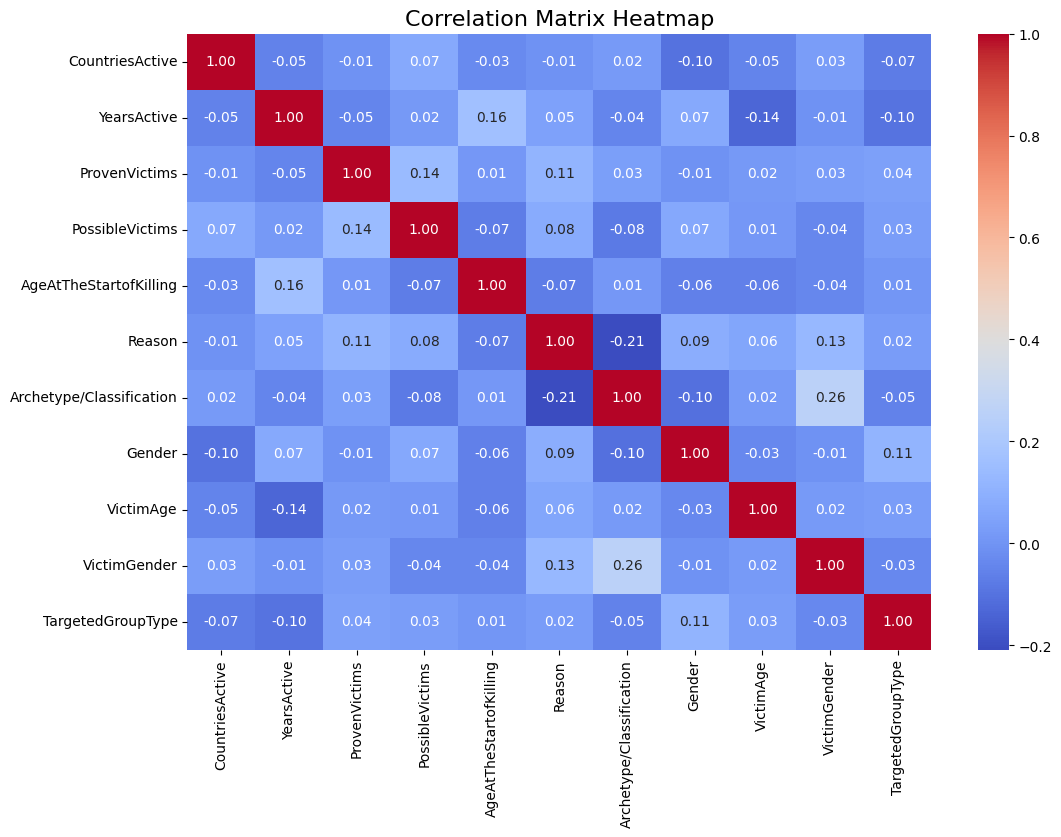

In [58]:
plt.figure(figsize=(12, 8))  
sns.heatmap(correlation_matrix, 
            annot=True,        
            fmt=".2f",         
            cmap="coolwarm",  
            cbar=True)         
plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.show()

In [59]:
# Assesing archetypes
unique_archetypes = df['Archetype/Classification'].unique()
print(unique_archetypes)

['Power/Control' 'Mission-Oriented (Hate-Crime/Targeted Groups)'
 'Hedonistic - Lust' 'Hedonistic' 'Power and Hedonistic' 'Visionary'
 'Hedonistic - Thrill' 'Hate Crime' 'Power' 'Profit Killer'
 'Power/Control - Lust']


In [60]:
# Filtering rows where the updated value is 'Hedonistic'
hedonistic_rows = df_copy[df_copy['Archetype/Classification'] == 'Hedonistic']
hedonistic_rows

,Name,Birthday,Countries Active,Years Active,Proven Victims,Possible Victims,BirthYear,StartYear,Age At The Start of Killing,Notes,Type,Nickname,Reason,Archetype/Classification,Gender,Victim Age,Victim Gender,Targeted Group Type
6,Hubert Pilcik,10/14/1891,Czech Republic,1948-1951,5,10,1891.0,1948.0,57.0,Pilcik made money smuggling people across the ...,"Financial Motive, Rapist, Sexual Predator",The Beast,"Financial Gain, Sexual Assault",Hedonistic,Male,Adult,Male,None
9,Hubert Pil?„ÂŤ??Â­k,10/14/1891,Czechoslovakia,1948-1951,5,10+,1891.0,1948.0,57.0,Made money smuggling people across the Czechos...,Financial Motive,NaN,Financial Gain,Hedonistic,Male,Adult,Male,None
12,Marie Alexandrine Becker,7/14/1879,Belgium,1933-1936,11,NaN,1879.0,1933.0,54.0,Poisoned wealthy clients while working as a se...,Unknown,NaN,Financial Gain,Hedonistic,Male,Adult,Mixed,None
16,Elfriede Blauensteiner,1/22/1931,Austria,1981-1995,3,10+,1931.0,1981.0,50.0,Poisoned people for material gain; died from a...,"Financial Motive, Medical",The Black Widow,Financial Gain,Hedonistic,Male,Adult,Mixed,None
22,Tamara Samsonova,4/25/1947,Russia,1995-2015,13,13+,1947.0,1995.0,48.0,Killed and allegedly cannibalized people in he...,Cannibal,"Granny Ripper, Baba Yaga",Cannibalism,Hedonistic,Female,Adult,Male,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,Süleyman Aktaş,NaN,Turkey,1986-1994,5,5,NaN,1986.0,NaN,"In 1986, he killed police superintendent Nuri...","Hate Crime, Stangler",The Nailing Killer,Thrill,Hedonistic,Male,Adult,Male,Elderly
635,Valery Asratyan,NaN,Russia,1988-1990,3,3,NaN,1988.0,NaN,During Valery Asratyan's crimes as a serial ki...,"Financial Motive, Rapist, Sexual Predator",The Director,"Financial Gain, Sexual Assault",Hedonistic,Male,Adult,Female,None
636,Dmitry Baksheev,NaN,Russia,1999-2017,1,30,NaN,1999.0,NaN,"Dmitry Baksheev, and his wife Natalia Baksheev...",Cannibal,Cannibal Couple,Cannibalism,Hedonistic,Male,Adult,Female,None
637,Natalia Baksheev,NaN,Russia,1999-2017,1,30,NaN,1999.0,NaN,"Natalia Baksheev, and her husband Dmitry Baksh...",Cannibal,Cannibal Couple,Cannibalism,Hedonistic,Female,Adult,Female,None


In [61]:
# Renaming archetypes to match the 4 relevant types mentioned in our research
df_copy['Archetype/Classification'] = df_copy['Archetype/Classification'].replace('Hedonistic - Lust', 'Hedonistic')
df_copy['Archetype/Classification'] = df_copy['Archetype/Classification'].replace('Hedonistic - Thrill', 'Hedonistic')
df_copy['Archetype/Classification'] = df_copy['Archetype/Classification'].replace('Profit Killer', 'Hedonistic')
df_copy['Archetype/Classification'] = df_copy['Archetype/Classification'].replace('Hate Crime', 'Missionary')
df_copy['Archetype/Classification'] = df_copy['Archetype/Classification'].replace('Mission-Oriented (Hate-Crime/Targeted Groups)', 'Missionary')


# Verifying the change
unique_archetypes = df_copy['Archetype/Classification'].unique()
print(unique_archetypes)


['Power/Control' 'Missionary' 'Hedonistic' 'Power and Hedonistic'
 'Visionary' 'Power' 'Power/Control - Lust']


In [62]:

# Filtering rows where the updated value is 'Hedonistic'
hedonistic_rows = df_copy[df_copy['Archetype/Classification'] == 'Power/Control']
hedonistic_rows

# Remove 'Hate Crime,' from the 'Type' column
df_copy['Type'] = df_copy['Type'].str.replace('Hate Crime, Medical', 'Medical', regex=False).str.strip()

# Verify the change
print(df_copy['Type'].unique())



['Unknown' 'Hate Crime' 'Hate Crime, Rapist, Sexual Predator'
 'Financial Motive, Rapist, Sexual Predator' 'Rapist, Sexual Predator'
 'Financial Motive' 'Torturer'
 'Cannibal, Pedophile, Rapist, Vampire, Cannibal, Torturer, Stalker, Sexual Predator, Vampire'
 'Financial Motive, Medical' 'Rapist, Stalker, Sexual Predator'
 'Rapist, Necrophiliac, Strangler, Sexual Predator'
 'Rapist, Strangler, Sexual Predator' 'Cannibal' 'Hate Crime, Strangler'
 'Rapist, Strangler, Pedophile, Sexual Predator'
 'Rapist, Torturer, Strangler, Sexual Predator' 'Sexual Predator'
 'Rapist, Pedophile, Strangler, Sexual Predator'
 'Financial Motive, Hate Crime' 'Hate Crime, Strangler, Torturer'
 'Financial Motive, Medical, Rapist, Torturer, Sexual Predator'
 'Financial Motive, Rapist, Torturer, Strangler, Sexual Predator'
 'Cannibal, Necrophiliac, Cannibal, Rapist, Sexual Predator'
 'Serial Killer, Rapist, Strangler, Vampire, Sexual Predator, Vampire'
 'Rapist, Torturer, Sexual Predator'
 'Rapist, Torturer, Str

In [63]:
# Count the number of missing (NaN) values in the 'Birthday' column
missing_birthday_count = df['Birthday'].isna().sum()

print(f"Number of missing values in the 'Birthday' column: {missing_birthday_count}")
# Drop rows where 'Birthday' is missing
df_cleaned = df_copy.dropna(subset=['Birthday'])

# Verify the result
print(f"Number of rows after dropping missing birthdays: {len(df_cleaned)}")



Number of missing values in the 'Birthday' column: 100
Number of rows after dropping missing birthdays: 539


In [64]:
# Filter rows where the updated value is 'Hedonistic'
hedonistic_rows = df_copy[df_copy['Archetype/Classification'] == 'Power and Hedonistic']
df_copy['Archetype/Classification'] = df_copy['Archetype/Classification'].replace('Power and Hedonistic', 'Power/Control')
df_copy['Archetype/Classification'] = df_copy['Archetype/Classification'].replace('Power', 'Power/Control')
# Filter rows where the updated value is 'Hedonistic'
hedonistic_rows = df_copy[df_copy['Archetype/Classification'] == 'Visionary']
hedonistic_rows


,Name,Birthday,Countries Active,Years Active,Proven Victims,Possible Victims,BirthYear,StartYear,Age At The Start of Killing,Notes,Type,Nickname,Reason,Archetype/Classification,Gender,Victim Age,Victim Gender,Targeted Group Type
49,L??Â©opold Dion,2/25/1920,Canada,1963,4,4,1920.0,1963.0,43.0,L??Â©opold Dion a Canadian sex offender and se...,Unknown,Monster of Port-Rouge,Mental Illness,Visionary,Male,Adult,Male,None
130,John George Haigh,7/24/1909,United Kingdom,1944-1949,6,9,1909.0,1944.0,35.0,Known as the Acid Bath Murderer for dissolving...,Vampire,Acid Bath Murderer,Religious,Visionary,Male,Adult,Mixed,None
150,Daniel Blank,6/28/1962,United States,1996-1997,6,6,1962.0,1996.0,34.0,He has a learning disability that hampers his ...,Visionary,NaN,Mental Illness,Visionary,Male,Adult,Mixed,Elderly
310,Robert Rozier,7/28/1955,United States,1981-1986,4,7,1955.0,1981.0,26.0,Rozier was a former American football defensiv...,Unknown,"Neariah Israel, Child of God",Religious,Visionary,Male,Child,Mixed,None
320,Herbert Mullin,4/18/1947,United States,1972-1973,13,NaN,1947.0,1972.0,25.0,"Despite detailed confessions, prosecutors deci...",Unknown,The Psychopath of Santa Cruz,Mental Illness,Visionary,Male,Adult,Male,None
387,Aaron Kosminski,9/11/1865,United Kingdom,1888-1891,5,11,1865.0,1888.0,23.0,Aaron Kosminski (Aron Mordke Kozmi?…Â„ski) a s...,Unknown,Jack the Ripper (possible),Mental Illness,Visionary,Male,Adult,Mixed,None
538,Nikolay Shubin,NaN,Russia,2004-2006,13,NaN,1956.0,2004.0,48.0,Paranoid schizophrenic who killed people who b...,Unknown,NaN,Mental Illness,Visionary,Male,Adult,Male,None
573,Tomas Maldonado Cera,NaN,Colombia,2002-2018,7,10,1971.0,2002.0,31.0,Killed people in Barranquila for the purpose o...,Unknown,The Satanist,Occult Ritual,Visionary,Male,Adult,Mixed,None


In [65]:

# Verify the change
unique_archetypes = df_copy['Archetype/Classification'].unique()
print(unique_archetypes)
hedonistic_rows = df_copy[df_copy['Archetype/Classification'] == 'Power/Control - Lust']
hedonistic_rows
df_copy['Archetype/Classification'] = df_copy['Archetype/Classification'].replace('Power/Control - Lust', 'Power/Control')
# Verify the change
unique_archetypes = df_copy['Archetype/Classification'].unique()
print(unique_archetypes)



['Power/Control' 'Missionary' 'Hedonistic' 'Visionary'
 'Power/Control - Lust']
['Power/Control' 'Missionary' 'Hedonistic' 'Visionary']


In [66]:
# Convert 'StartYear' and 'EndYear' columns to whole numbers (integer type)
df_cleaned['Age At The Start of Killing'] = df_cleaned['AgeAtTheStartofKilling'].astype(int)

# Verify the changes
print(df_cleaned.dtypes)



KeyError: 'AgeAtTheStartofKilling'

In [ ]:
# Convert 'StartYear' and 'EndYear' columns to whole numbers (integer type)
df_cleaned['Age At The Start of Killing'] = df_cleaned['Age At The Start of Killing'].astype(int)

# Verify the changes
print(df_cleaned.dtypes)



IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [97]:
from datetime import datetime

# Drop rows where 'Birthday' is missing
df_regression = df_copy.dropna(subset=['Birthday'])
#Drop rows where Age at start of killing is missing

df_regression = df_regression.dropna(subset=['Age At The Start of Killing'])
# Print missing values and data types for all columns
for column in df_regression.columns:
    missing_count = df_regression[column].isnull().sum()
    data_type = df_regression[column].dtype
    print(f"{column}: {missing_count} missing values, Data Type: {data_type}")



# Print unique values in the 'Victim Age' column
print(df_regression['Proven Victims'].unique())

# Define the specific datetime values to check
datetime_2015 = datetime(2015, 8, 1, 0, 0)
datetime_2016 = datetime(2016, 11, 1, 0, 0)
datetime_2013= datetime(2013, 9, 1, 0, 0)


# Count occurrences of both datetime values
combined_count = df_regression['Proven Victims'].apply(
    lambda x: x in [datetime_2015, datetime_2016, datetime_2013]
).sum()

# Print the combined count
print(f"Occurrences of {datetime_2015} and {datetime_2016} and {datetime_2013}: {combined_count}")

# Remove rows with specific datetime values from the 'Proven Victims' column
df_regression_cleaned = df_regression[
    ~df_regression['Proven Victims'].apply(
        lambda x: x in [datetime(2015, 8, 1, 0, 0), datetime(2016, 11, 1, 0, 0), datetime(2013, 9, 1, 0, 0)]
    )
]
# Replace the value '103+' with '103' in the 'Proven Victims' column
df_regression_cleaned['Proven Victims'] = df_regression_cleaned['Proven Victims'].replace('103+', 103)

# Print unique values in the 'Victim Age' column
print(df_regression_cleaned['Proven Victims'].unique())

# Print the data type of the 'Proven Victims' column
print(f"Data type of 'Proven Victims': {df_regression_cleaned['Proven Victims'].dtype}")





Name: 0 missing values, Data Type: object
Birthday: 0 missing values, Data Type: object
Countries Active: 0 missing values, Data Type: object
Years Active: 0 missing values, Data Type: object
Proven Victims: 0 missing values, Data Type: object
Possible Victims: 40 missing values, Data Type: object
BirthYear: 0 missing values, Data Type: float64
StartYear: 0 missing values, Data Type: float64
Age At The Start of Killing: 0 missing values, Data Type: float64
Notes: 7 missing values, Data Type: object
Type: 0 missing values, Data Type: object
Nickname: 140 missing values, Data Type: object
Reason: 0 missing values, Data Type: object
Archetype/Classification: 0 missing values, Data Type: object
Gender: 0 missing values, Data Type: object
Victim Age: 0 missing values, Data Type: object
Victim Gender: 0 missing values, Data Type: object
Targeted Group Type: 0 missing values, Data Type: object
[5 3 9 6 4 7 1 11 33 13 17 16 72 8 14 datetime.datetime(2016, 11, 1, 0, 0)
 10 2 100 53 15 27 42 24 

C:\Users\camil\AppData\Local\Temp\ipykernel_12576\4012282581.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression_cleaned['Proven Victims'] = df_regression_cleaned['Proven Victims'].replace('103+', 103)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#it's pretty bad but makees sense since all of the feature arent very correlated with the target

# Define the columns to keep
selected_columns = ["Countries Active", "BirthYear", "StartYear", "Age At The Start of Killing",
                    "Reason", "Archetype/Classification", "Gender", "Victim Age", 
                    "Victim Gender", "Targeted Group Type"]

# Create a subset of df_regression with only the selected columns
df_regression_limited = df_regression[selected_columns].copy()

# Ensure all columns with lists are converted to strings
columns_with_lists = ['Countries Active', 'Reason', 'Gender', 'Victim Gender', 'Targeted Group Type', 'Victim Age']
for col in columns_with_lists:
    df_regression_limited[col] = df_regression_limited[col].apply(lambda x: ','.join(x) if isinstance(x, list) else x)

# Encode the target column `Archetype/Classification` with LabelEncoder
label_encoder = LabelEncoder()
df_regression_limited['Archetype/Classification'] = label_encoder.fit_transform(df_regression_limited['Archetype/Classification'])

# Label-encode remaining categorical columns to ensure all data is numeric
for col in ['Victim Age', 'Countries Active', 'Reason', 'Gender', 'Victim Gender', 'Targeted Group Type']:
    if df_regression_limited[col].dtype == 'object':
        le = LabelEncoder()
        df_regression_limited[col] = le.fit_transform(df_regression_limited[col])

# Define features (X) and target (y)
X = df_regression_limited.drop(columns=['Archetype/Classification'])
y = df_regression_limited['Archetype/Classification']

# Split data into training and remaining (test + validation) sets
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the remaining data equally into test and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)
y_val_pred = lr.predict(X_val_scaled)

# Performance Metrics Function
def print_metrics(y_true, y_pred, dataset_name):
    print(f"{dataset_name} Performance:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.2f}")
    print(f"R2 Score: {r2_score(y_true, y_pred):.2f}\n")

# Print Metrics
print_metrics(y_train, y_train_pred, "Training")
print_metrics(y_test, y_test_pred, "Testing")
print_metrics(y_val, y_val_pred, "Validation")




Training Performance:
MAE: 0.66
MSE: 0.67
R2 Score: 0.30

Testing Performance:
MAE: 0.76
MSE: 0.84
R2 Score: 0.12

Validation Performance:
MAE: 0.82
MSE: 1.03
R2 Score: -0.02

